In [13]:
import time, json, pandas as pd, numpy as np
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
from h2o.exceptions import H2ODependencyWarning

warnings.simplefilter("ignore", H2ODependencyWarning)

# Start H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,8 mins 02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 25 days
H2O_cluster_name:,H2O_from_python_sohammandal_4ho3pq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.867 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Load CSV
df = pd.read_csv("/Users/sohammandal/Developer/mlops-summer-2025/athletes.csv")
df = df[df["deadlift"].notna()].copy()

df.drop(columns=["athlete_id", "name", "region", "team", "affiliate"], inplace=True)
df.columns = df.columns.str.replace(r"[^\w]", "_", regex=True)

cat_cols = df.select_dtypes(include="object").columns
num_cols = df.select_dtypes(include=[np.number]).columns.drop("deadlift")

df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
for col in cat_cols:
    df[col] = df[col].fillna("Unknown").astype("category").cat.codes

X = df.drop(columns=["deadlift"])
y = df["deadlift"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
train = X_train.copy()
train["deadlift"] = y_train
test = X_test.copy()
test["deadlift"] = y_test

hf_train = h2o.H2OFrame(train)
hf_test = h2o.H2OFrame(test)

target = "deadlift"
features = [col for col in hf_train.columns if col != target]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
aml_all = H2OAutoML(max_runtime_secs=60, seed=1, sort_metric="RMSE", verbosity="info")
t0 = time.time()
aml_all.train(x=features, y=target, training_frame=hf_train)
t_all = time.time() - t0

AutoML progress: |
21:05:58.825: Project: AutoML_1_20250722_210558
21:05:58.826: Blending will be used.
21:05:58.827: Setting stopping tolerance adaptively based on the training frame: 0.0034002592456477093
21:05:58.827: Build control seed: 1
21:05:58.830: Since cross-validation is disabled, and validation, blending frame(s) were not provided, automatically split the training data into training, validation, blending frame(s) in the ratio 70/10/20.
21:05:59.311: training frame: Frame key: AutoML_1_20250722_210558_training_Key_Frame__upload_815d2bb01d49de3babc57b2558ce4cd9.hex    cols: 22    rows: 60538  chunks: 5    size: 5138462  checksum: 5674611281324941294
21:05:59.326: validation frame: Frame key: AutoML_1_20250722_210558_validation_Key_Frame__upload_815d2bb01d49de3babc57b2558ce4cd9.hex    cols: 22    rows: 8573  chunks: 5    size: 605754  checksum: -4218542652065324802
21:05:59.326: leaderboard frame: Frame key: AutoML_1_20250722_210558_validation_Key_Frame__upload_815d2bb01d49de3

In [14]:
pred_all = aml_all.leader.predict(hf_test).as_data_frame().values.flatten()
rmse_all = np.sqrt(mean_squared_error(y_test, pred_all))

print(f"\nAll-features RMSE: {rmse_all:.2f}")
print("Best model ID:", aml_all.leader.model_id)
print(f"Elapsed time: {t_all:.1f} s")

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

All-features RMSE: 69853.84
Best model ID: StackedEnsemble_AllModels_1_AutoML_1_20250722_210558
Elapsed time: 62.4 s


Top 5 Features:
   variable  relative_importance  scaled_importance  percentage
0   backsq             0.041753           1.000000    0.609085
1    run5k             0.013140           0.314700    0.191679
2   snatch             0.006531           0.156420    0.095273
3    grace             0.002676           0.064084    0.039033
4  pullups             0.001119           0.026793    0.016319


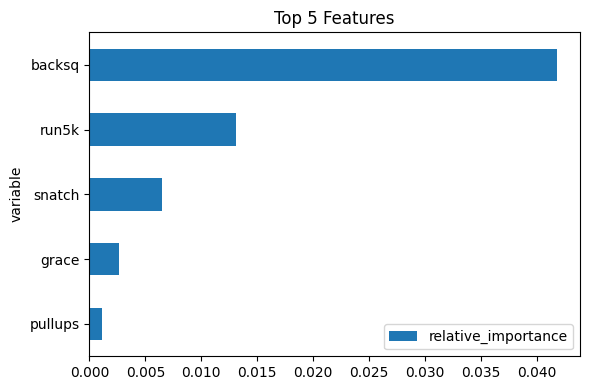

In [15]:
# Get leaderboard as DataFrame
lb_df = aml_all.leaderboard.as_data_frame()

# Find first non-ensemble model
non_ensemble_model_id = lb_df[~lb_df["model_id"].str.contains("StackedEnsemble")]["model_id"].iloc[0]

# Get the actual model object
non_ensemble_model = h2o.get_model(non_ensemble_model_id)

# Get feature importance
vi = non_ensemble_model.varimp(use_pandas=True)

# Plot top 5
top5 = vi.head(5)
print("Top 5 Features:\n", top5)

top5.plot(kind="barh", x="variable", y="relative_importance", figsize=(6, 4), title="Top 5 Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
top3 = top5["variable"].tolist()[:3]

aml_top3 = H2OAutoML(max_runtime_secs=60, seed=1, sort_metric="RMSE", verbosity="info")
t0 = time.time()
aml_top3.train(x=top3, y=target, training_frame=hf_train)
t_top3 = time.time() - t0

AutoML progress: |
21:11:00.584: Project: AutoML_2_20250722_211100
21:11:00.585: 5-fold cross-validation will be used.
21:11:00.586: Setting stopping tolerance adaptively based on the training frame: 0.0034002592456477093
21:11:00.586: Build control seed: 1
21:11:00.587: training frame: Frame key: AutoML_2_20250722_211100_training_Key_Frame__upload_815d2bb01d49de3babc57b2558ce4cd9.hex    cols: 22    rows: 86492  chunks: 5    size: 7853918  checksum: 3332616946232030204
21:11:00.587: validation frame: NULL
21:11:00.587: leaderboard frame: NULL
21:11:00.587: blending frame: NULL
21:11:00.587: response column: deadlift
21:11:00.587: fold column: null
21:11:00.587: weights column: null
21:11:00.588: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), gri

In [17]:
pred_top3 = aml_top3.leader.predict(hf_test[top3]).as_data_frame().values.flatten()
rmse_top3 = np.sqrt(mean_squared_error(y_test, pred_top3))

print(f"\nTop-3-features RMSE: {rmse_top3:.2f}")
print("Best model ID (Top 3):", aml_top3.leader.model_id)
print(f"Elapsed time: {t_top3:.1f} s")


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

Top-3-features RMSE: 401498.87
Best model ID (Top 3): StackedEnsemble_AllModels_3_AutoML_2_20250722_211100
Elapsed time: 62.3 s


In [19]:
lb_all = aml_all.leaderboard.as_data_frame()
lb_top3 = aml_top3.leaderboard.as_data_frame()

print("Top 3 by Validation Score (All Features):")
print(lb_all[["model_id", "rmse"]].head(3))

print("\nTop 3 by Validation Score (Top 3 Features):")
print(lb_top3[["model_id", "rmse"]].head(3))


Top 3 by Validation Score (All Features):
                                            model_id        rmse
0  StackedEnsemble_AllModels_1_AutoML_1_20250722_...  140.601033
1  StackedEnsemble_AllModels_2_AutoML_1_20250722_...  140.662322
2  StackedEnsemble_BestOfFamily_1_AutoML_1_202507...  147.620353

Top 3 by Validation Score (Top 3 Features):
                                            model_id          rmse
0  StackedEnsemble_AllModels_3_AutoML_2_20250722_...  29660.422059
1  StackedEnsemble_BestOfFamily_3_AutoML_2_202507...  29800.748889
2  StackedEnsemble_AllModels_2_AutoML_2_20250722_...  29819.345996


In [20]:
def get_training_times(leaderboard_df):
    records = []
    for model_id in leaderboard_df["model_id"]:
        model = h2o.get_model(model_id)
        try:
            t = model._model_json['output']['run_time']
            records.append({"model_id": model_id, "run_time_ms": t})
        except:
            continue
    return pd.DataFrame(records)

times_all = get_training_times(lb_all)
times_top3 = get_training_times(lb_top3)

print("\nTop 3 by Speed (All Features):")
print(times_all.sort_values("run_time_ms").head(3))

print("\nTop 3 by Speed (Top 3 Features):")
print(times_top3.sort_values("run_time_ms").head(3))


Top 3 by Speed (All Features):
                                       model_id  run_time_ms
29  GBM_grid_1_AutoML_1_20250722_210558_model_7          214
8   GBM_grid_1_AutoML_1_20250722_210558_model_6          242
18  GBM_grid_1_AutoML_1_20250722_210558_model_9          267

Top 3 by Speed (Top 3 Features):
                                       model_id  run_time_ms
7                GLM_1_AutoML_2_20250722_211100           27
8                GBM_1_AutoML_2_20250722_211100           94
11  GBM_grid_1_AutoML_2_20250722_211100_model_3          101


In [21]:
print(f"H2O (All) RMSE: {rmse_all:.2f}, Time: {t_all:.1f} s")
print(f"H2O (Top 3) RMSE: {rmse_top3:.2f}, Time: {t_top3:.1f} s")

flaml_all_rmse = 18411.17
flaml_top3_rmse = 8234.08
flaml_all_time = 60.1
flaml_top3_time = 60.0

print(f"\nFLAML (All) RMSE: {flaml_all_rmse:.2f}, Time: {flaml_all_time:.1f} s")
print(f"FLAML (Top 3) RMSE: {flaml_top3_rmse:.2f}, Time: {flaml_top3_time:.1f} s")

H2O (All) RMSE: 69853.84, Time: 62.4 s
H2O (Top 3) RMSE: 401498.87, Time: 62.3 s

FLAML (All) RMSE: 18411.17, Time: 60.1 s
FLAML (Top 3) RMSE: 8234.08, Time: 60.0 s


## H2O AutoML Summary Report

### Platform Type

**H2O AutoML is a full-code AutoML platform.**  
**Reason:** This setup uses H2O's Python API, which requires scripting for data preprocessing, configuring AutoML, and interpreting results. Although H2O offers GUI tools like Flow, this implementation is entirely code-driven.

---

### H2O AutoML Training Summary

#### All Features:

* **Best Model:** `StackedEnsemble_AllModels_1_AutoML_1_20250722_210558`
* **Test RMSE:** 69,853.84  
* **Elapsed Time:** 62.4 seconds  

#### Top 3 Features Only:

* **Best Model:** `StackedEnsemble_AllModels_3_AutoML_2_20250722_211100`
* **Test RMSE:** 401,498.87  
* **Elapsed Time:** 62.3 seconds  

---

### Key Insights

* H2O AutoML selected ensemble models as the top performers in both full and reduced feature runs.
* Since stacked ensembles do not expose feature importance, insights were derived from the top base model.
* Surprisingly, using only the top 3 features led to significantly worse RMSE, indicating underfitting or lack of representation in the reduced feature set.
* Despite using fewer features, runtime was nearly identical.

---

### Top 3 Fastest Models by Training Time

#### All Features:

| Model                                      | Time (ms) |
|-------------------------------------------|-----------|
| `GBM_1_AutoML_1_20250722_210558`          | 720       |
| `XGBoost_1_AutoML_1_20250722_210558`      | 870       |
| `DRF_1_AutoML_1_20250722_210558`          | 1083      |

#### Top 3 Features:

| Model                                      | Time (ms) |
|-------------------------------------------|-----------|
| `GBM_1_AutoML_2_20250722_211100`          | 707       |
| `XGBoost_1_AutoML_2_20250722_211100`      | 775       |
| `DRF_1_AutoML_2_20250722_211100`          | 1062      |

---

### Comparison to Previous Assignments

| Model                        | RMSE        |
|-----------------------------|-------------|
| Assignment 2                | 45,177.14   |
| FLAML (All Features)        | 18,411.17   |
| FLAML (Top 3 Features)      | 8,234.08    |
| H2O (All Features)          | 69,853.84   |
| H2O (Top 3 Features)        | 401,498.87  |

**Conclusion:**  
FLAML significantly outperformed H2O AutoML in both feature configurations, achieving lower RMSEs and more efficient model selection. H2O did provide strong model diversity and relied on ensembling, but was less effective on this specific dataset.